In [1]:
%matplotlib inline

# import packages

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np
import sqlite3
import sklearn
from sklearn.linear_model import LogisticRegression
from pandas.io import sql
from matplotlib.ticker import ScalarFormatter


# Data Cleaning

In [2]:
# Select only the relevant columns
pop_cols = ['AGEP','SEX','HISP','POBP','RAC1P','SCIENGP','SOCP']

In [3]:
# Load the data
df = pd.concat([pd.read_csv("df_main.csv", usecols=pop_cols)])

In [4]:
df.head()
# HISP - Recoded detailed Hispanic origin 
# POBP - Place of birth
# RAC1P - Recoded detailed race code
# SCIENGP - Field of Degree Science and Engineering Flag – NSF Definition
# SOC Occupation code for 2012 and later based on 2010 SOC codes   

,AGEP,SEX,HISP,POBP,RAC1P,SCIENGP,SOCP
0,19,1,1,28,1,NaN,NaN
1,55,1,1,1,2,NaN,411011
2,56,0,1,1,2,NaN,493050
3,21,0,1,1,2,NaN,NaN
4,21,1,1,1,2,NaN,NaN


In [5]:
# Recode place of birth variable with state names
oldNewMap = {1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "District_of_Columbia",
12: "Florida", 13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois", 18: "Indiana",
19: "Iowa", 20: "Kansas", 21: "Kentucky", 22: "Louisiana", 23: "Maine", 24: "Maryland",
25: "Massachusetts", 26: "Michigan", 27: "Minnesota", 28: "Mississippi", 29: "Missouri",
30: "Montana", 31: "Nebraska", 32: "Nevada", 33: "New_Hampshire", 34: "New_Mexico",
35: "New_Jersey", 36: "New_York", 37: "North_Carolina", 38: "North_Dakota", 39: "Ohio",
40: "Oklahoma", 41: "Oregon", 42: "Pennsylvania", 44: "Rhode_Island", 45: "South_Carolina",
46: "South_Dakota", 47: "Tennessee", 48: "Texas", 49: "Utah", 50: "Vermont", 51: "Virginia",
53: "Washington", 54: "West_Virginia", 55: "Wisconsin", 56: "Wyoming"}
df['State'] = df['POBP'].map(oldNewMap)

In [6]:
# recode sex variable
# First, change the integers that are used for coding.
# Right now, male = 1 and female = 2.
# to fit in a regression model they should be recoded to 0 and 1
if np.min(df['SEX']) > 0: #ensures that code won't be run if it's been recoded already
    df['SEX'] = df['SEX'] - 1
# Next, create a new column with Male/Female labels
oldNewMap = {0: "Male", 1: "Female"}
df['sex_recode'] = df['SEX'].map(oldNewMap)


In [7]:
# Recode race
# I will be using different categories than are used in the census data.
# All individuals of Hispanic origin will be categorized as Hispanic.
# Non-Hispanic White, Non-Hispanic Black and Asian will be included as categories.
# All other races are coded as "Other"
def race_recode(row):
    if row['HISP'] > 1:
        return "Hispanic"
    elif row['RAC1P'] == 1:
        return "White"
    elif row['RAC1P'] == 2:
        return "Black"
    elif row['RAC1P'] == 6:
        return "Asian"
    else:
        return "Other"
df['race_recode'] = df.apply(race_recode, axis=1)


In [8]:
# recode the HISP variable for easy readability
oldNewMap = {1: "Not Spanish/Hispanic/Latino", 2: "Mexican", 3: "Puerto Rican", 4: "Cuban", 
             5: "Dominican", 6: "Costa Rican", 7: "Guatemalan", 8: "Honduran", 9: "Nicaraguan",
            10: "Panamanian", 11: "Salvadorian", 12: "Other Central American", 13: "Argentinian",
            14: "Bolivian", 15: "Chilean", 16: "Colombian", 17: "Ecuadorian", 18: "Paraguayan",
            19: "Peruvian", 20: "Uruguayan", 21: "Venezuelan", 22: "Other South American",
            23: "Spaniard", 24: "All Other Spanish/Hispanic/Latino"}
df['detailed_hispanic_origin'] = df['HISP'].map(oldNewMap)

In [9]:
# Create STEM degree outcome variable
oldNewMap = {1: 1, 2: 0}
df['science_degree'] = df['SCIENGP'].map(oldNewMap)
df['science_degree'].fillna(value=0,inplace=True) # map doesn't include NA values, so they must be filled with zeroes

# Create STEM occupation outcome variable

science_job_codes = ['113021','119041','119121','151111','151121','151122','151131','151132','151133',
                          '151134','151141','151142','151143','151151','151152','151199','152011','152021',
                          '152031','152041','152099','171021','171022','172011','172021','172031','172041',
                          '172051','172061','172071','172072','172081','172111','172112','172121','172131',
                          '172141','172151','172161','172171','172199','173012','173013','173019','173021',
                          '173022','173023','173024','173025','173026','173027','173029','173031','191011',
                          '191012','191012','191021','191022','191023','191029','191031','191032','191041',
                          '191042','191099','192011','192012','192021','192031','192032','192041','192042',
                          '192043','192099','194011','194021','194031','194041','194051','194091','194092',
                          '194093','251021','251022','251032','251041','251042','251043','251051','251052',
                          '251053','251054','414011','419031']
df['science_occupation'] = df['SOCP'].isin(science_job_codes).astype(int)

In [10]:
df.pivot_table(index='detailed_hispanic_origin',values='science_degree',aggfunc='count').sort_values(ascending=False,by = "science_degree")
# Mexican, Puerto Rican, and Cuban have enough samples to remain their own categories. 
# The rest should be consolidated based on geographic proximity and similarity in outcomes.

,science_degree
detailed_hispanic_origin,
Not Spanish/Hispanic/Latino,2697368
Mexican,280127
Puerto Rican,40523
Cuban,17355
All Other Spanish/Hispanic/Latino,16191
Salvadorian,14762
Dominican,12368
Guatemalan,9444
Colombian,8751


In [11]:
# compare Hispanic origins by rates of science degrees
df.pivot_table(index='detailed_hispanic_origin',values='science_degree',aggfunc='mean').sort_values(ascending=False, by = "science_degree")

,science_degree
detailed_hispanic_origin,
Venezuelan,0.154179
Argentinian,0.144395
Chilean,0.135540
Bolivian,0.104097
Colombian,0.093018
Spaniard,0.089738
Peruvian,0.085939
Not Spanish/Hispanic/Latino,0.085489
Costa Rican,0.081866


In [12]:
# compare Hispanic origins by rates of science occupations
df.pivot_table(index='detailed_hispanic_origin',values='science_occupation',aggfunc='mean').sort_values(ascending=False, by = "science_occupation")

,science_occupation
detailed_hispanic_origin,
Chilean,0.021277
Venezuelan,0.021134
Argentinian,0.019731
Paraguayan,0.019231
Spaniard,0.018961
Not Spanish/Hispanic/Latino,0.016850
Bolivian,0.016611
Costa Rican,0.014965
Other South American,0.013761


In [13]:
# recode hispanic origin into 7 categories
oldNewMap = {1: "Not Spanish/Hispanic/Latino", 2: "Mexican", 3: "Puerto_Rican", 4: "Cuban", 
            5: "Other_Central_American", 6: "Other_Central_American", 7: "Other_Central_American", 
            8: "Other_Central_American", 9: "Other_Central_American", 10: "Other_Central_American", 
            11: "Other_Central_American", 12: "Other_Central_American", 13: "South_American",
            14: "South_American", 15: "South_American", 16: "South_American", 17: "South_American", 
            18: "South_American", 19: "South_American", 20: "South_American", 21: "South_American", 
            22: "South_American", 23: "Spaniard", 24: "All_Other_Hispanic"}       
df['hisp_recode'] = df['HISP'].map(oldNewMap)

#In both of these tables, the South American countries (Venezuela, Argentina, Chile, Bolivia, Colombia, Peru, Uruguay, Ecuador, Paraguay) have fairly similar success rates of the outcomes.

#The Central American countries (Costa Rica, Panama, Nicaragua, Dominican Republic, Guatemala, Honduras, El Salvador) generally have similar success rates as well.

#Spain is the only European country listed cannot be included in any broader category.

#Based on this analysis, I recoded the detailed hispanic origin variable into 7 categories: Mexican, Puerto Rican, Cuban, Spaniard, Other Central American, South American, All Other Spanish/Hispanic/Latino.

In [47]:
len(df)

3132795

In [15]:

# Next, I had to reformat the data to work in a logistic regression. I had to:

# Add an intercept term
# Add an interaction variable between sex and age
# Create dummy variables
# add intercept for use in logistic regression model
df['intercept'] = 1.0

# add interaction term
df['sex_age'] = df['SEX'] * df['AGEP']

# dummy variables

# Pandas has a great function get_dummies that does all the work of
# creating dummy variables, and then you just have to join them.
# HOWEVER, this is memory intensive, so I will use a less memory intensive
# method of creating small tables for the dummy variables,
# and merging them using SQL

# state dummy variables
# Pennsylvania was omitted as the reference category due to its being
# a fairly large state that scored close to the average on outcome
states_to_include = ['Alabama','Alaska','Arizona','Arkansas','California',
                     'Colorado','Connecticut','Delaware','District_of_Columbia','Florida',
                     'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa',
                     'Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
                     'Michigan','Minnesota','Mississippi','Missouri','Montana',
                     'Nebraska','Nevada','New_Hampshire','New_Jersey','New_Mexico',
                     'New_York','North_Carolina','North_Dakota','Ohio','Oklahoma',
                     'Oregon','Rhode_Island','South_Carolina','South_Dakota',
                     'Tennessee','Texas','Utah','Vermont','Virginia','Washington',
                     'West_Virginia','Wisconsin','Wyoming']

# create blank data frame (and add back Pennsylvania)
dummy_states = pd.DataFrame(index=(states_to_include+['Pennsylvania']),columns=states_to_include)

# for each state, when the index equals the column, include a 1
for state in states_to_include:
    dummy_states.at[state, state] =  1
    
# fill in zeroes for all other variables
dummy_states.fillna(value=0,inplace=True)
dummy_states.head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District_of_Columbia,Florida,...,South_Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West_Virginia,Wisconsin,Wyoming
Alabama,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alaska,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arizona,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arkansas,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
California,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Now, we do the same with race, using White as reference category

races_to_include = ['Black','Hispanic','Asian','Other']
dummy_race = pd.DataFrame(index=(races_to_include+['White']),columns=races_to_include)
for race in races_to_include:
    dummy_race.at[race, race] =  1
dummy_race.fillna(value=0,inplace=True)

In [17]:
# For Hispanic origin, Non-Hispanic is the reference category.
# In my final models, these will replace 'Hispanic' because they are more predictive.
# For some insight as to why different groups of Hispanics should not be treated
# as a single race in this model, I've covered that in another blog post:
# https://michaelinkles.wordpress.com/2016/03/12/whats-special-about-florida/

hisp_to_include = ['Mexican','Puerto_Rican','Cuban','Other_Central_American',
'South_American','Spaniard','All_Other_Hispanic']
dummy_hisp = pd.DataFrame(index=(hisp_to_include+['Not Spanish/Hispanic/Latino']),columns=hisp_to_include)
for hisp in hisp_to_include:
      dummy_hisp.at[hisp, hisp] =  1
dummy_hisp.fillna(value=0,inplace=True)

# To join the dummy variables, I created a SQLite database to store each table,
# then combined them into one big data frame using a SQL query

# Connect to SQLite
conn = sqlite3.connect('dat-test.db')
df.to_sql('df_main',con=conn,if_exists='replace',index=False)
dummy_states.to_sql('states',con=conn,if_exists='replace',index=True, index_label='State')
dummy_race.to_sql('races',con=conn,if_exists='replace',index=True, index_label='Race')
dummy_hisp.to_sql('hispanic_origins',con=conn,if_exists='replace',index=True, index_label='Hisp')

In [49]:
len(df)

3132795

In [18]:
# In creating the final dataframe I'm using for the model,
# I want to subset out only people born in the 50 states or DC (so I can use State of Birth)
# who are over age 22 (so they are old enough to have a college degree)
# I could have done this earlier, but the most efficient way is to make it
# part of the SQL query that I'm doing anyway.
model_df = sql.read_sql(
"""
SELECT a.intercept, a.AGEP, a.SEX, a.sex_age, r.Asian, r.Black, r.Other, h.Mexican,
h.Puerto_Rican, h.Cuban, h.Spaniard, h.South_American, h.Other_Central_American, 
h.All_Other_Hispanic, s.Alabama, s.Alaska, s.Arizona, s.Arkansas, s.California,
s.Colorado, s.Connecticut,s.Delaware,s.District_of_Columbia,s.Florida,
s.Georgia,s.Hawaii,s.Idaho,s.Illinois,s.Indiana,s.Iowa,
s.Kansas,s.Kentucky,s.Louisiana,s.Maine,s.Maryland,s.Massachusetts,
s.Michigan,s.Minnesota,s.Mississippi,s.Missouri,s.Montana,
s.Nebraska,s.Nevada,s.New_Hampshire,s.New_Jersey,s.New_Mexico,
s.New_York,s.North_Carolina,s.North_Dakota,s.Ohio,s.Oklahoma,
s.Oregon,s.Rhode_Island,s.South_Carolina,s.South_Dakota,
s.Tennessee,s.Texas,s.Utah,s.Vermont,s.Virginia,s.Washington,
s.West_Virginia,s.Wisconsin,s.Wyoming, a.science_degree, a.science_occupation, a.POBP
FROM df_main as a
JOIN states as s
ON a.State = s.State
JOIN races as r
ON a.race_recode = r.Race
JOIN hispanic_origins as h
on a.hisp_recode = h.Hisp
WHERE a.AGEP > 22 and a.POBP < 60
""", con=conn)

In [19]:
model_df.head()

,intercept,AGEP,SEX,sex_age,Asian,Black,Other,Mexican,Puerto_Rican,Cuban,...,Utah,Vermont,Virginia,Washington,West_Virginia,Wisconsin,Wyoming,science_degree,science_occupation,POBP
0,1.0,55,1,55,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,1
1,1.0,56,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,1
2,1.0,63,1,63,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,1
3,1.0,61,1,61,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.0,0,1
4,1.0,78,1,78,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,1


In [44]:
df.describe()

,AGEP,SEX,HISP,POBP,RAC1P,SCIENGP,science_degree,science_occupation,intercept,sex_age
count,3.132795e+06,3.132795e+06,3.132795e+06,3.132795e+06,3.132795e+06,683328.000000,3.132795e+06,3.132795e+06,3132795.0,3.132795e+06
mean,4.045884e+01,5.120223e-01,1.541282e+00,5.757713e+01,1.861020e+00,1.641147,7.827324e-02,1.536775e-02,1.0,2.132572e+01
std,2.347346e+01,4.998555e-01,2.592473e+00,8.349859e+01,2.064364e+00,0.479664,2.686011e-01,1.230105e-01,0.0,2.691206e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,2.000000e+01,0.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,1.000000,0.000000e+00,0.000000e+00,1.0,0.000000e+00
50%,4.100000e+01,1.000000e+00,1.000000e+00,3.600000e+01,1.000000e+00,2.000000,0.000000e+00,0.000000e+00,1.0,2.000000e+00
75%,5.900000e+01,1.000000e+00,1.000000e+00,4.800000e+01,1.000000e+00,2.000000,0.000000e+00,0.000000e+00,1.0,4.400000e+01
max,9.500000e+01,1.000000e+00,2.400000e+01,5.540000e+02,9.000000e+00,2.000000,1.000000e+00,1.000000e+00,1.0,9.500000e+01


In [46]:
len(model_df)

1900073

In [45]:
len(df)

3132795

# Model Building 

For STEM degree model, include Age, Sex, Age Sex interaction, race including detailed hispanic origin, and state of birth.

For STEM occupation model, I removed the states because they turned out to not be significantly predictive. STEM occupation model is also built on a subset of only the people in my sample who have degrees in STEM.

In [20]:
# Define degree model columns
train_cols_degree = ['intercept','AGEP','SEX','sex_age','Asian','Black','Other',
'Mexican','Puerto_Rican','Cuban','Spaniard','South_American',
'Other_Central_American','All_Other_Hispanic'] + states_to_include

# Other_Central_American includes 5 Dominican, 6 Costa Rican, 7 Guatemalan 8 Honduran, 9 Nicaraguan, 10 Panamanian, 11 Salvadorian, 12 Other Central American

# Fit degree model
lm_final_degree = LogisticRegression()
lm_final_degree.fit(model_df[train_cols_degree],model_df['science_degree'])


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
# Define occupation model columns
train_cols_occ = ['intercept','AGEP','SEX','sex_age','Asian','Black','Other',
'Mexican','Puerto_Rican','Cuban','Spaniard','South_American',
'Other_Central_American','All_Other_Hispanic']

# Subset only STEM degree holders for occupation model
df_degree = model_df[model_df['science_degree']==1]

# Fit occupation model
lm_final_occ = LogisticRegression()
lm_final_occ.fit(df_degree[train_cols_occ],df_degree['science_occupation'])

LogisticRegression()

## Build the degree model

$P(Degree = 1 | X) = sigmoid(\beta X)$

where $X$ is feature matrix containing vectors of intercept, AGEP, SEX, sex_age, Asian, Black, Other,
Mexican, Puerto_Rican, Cuban, Spaniard, South_American, Other_Central_American and All_Other_Hispanic

In [22]:
# fit degree model
logit_degree = sm.Logit(model_df['science_degree'], model_df[train_cols_degree]) 

In [23]:
result_degree = logit_degree.fit()
result_degree.summary()

Optimization terminated successfully.
         Current function value: 0.312173
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         science_degree   No. Observations:              1900073
Model:                          Logit   Df Residuals:                  1900009
Method:                           MLE   Df Model:                           63
Date:                Tue, 22 Feb 2022   Pseudo R-squ.:                 0.04296
Time:                        12:07:40   Log-Likelihood:            -5.9315e+05
converged:                       True   LL-Null:                   -6.1978e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -1.8314      0.014   -126.743      0.000      -1.860      -1.803
AGEP                      -0.0004      0.000     -2.232      0.026      -0.001   -5.26e-05
SEX                        0.9635      0.015     62.294      0.000       0.933       0.994
sex_age                   -0.0294      0.000    -97.484      0.000      -0.030      -0.029
Asian                      0.9746      0.018     54.050      0.000       0.939       1.010
Black                     -0.7684      0.011    -71.400      0.000      -0.790      -0.747
Other                     -0.3697      0.018    -21.084      0.000      -0.404      -0.335
Mexican                   -0.9493      0.017    -55.453      0.000      -0.983      -0.916
Puerto_Rican              -0.8848      0.034    -25.814      0.000      -0.952      -0.818
Cuban                      0.0528      0.050      1.048      0.294      -0.046       0.151
Spaniard                  -0.1308      0.055     -2.389      0.017      -0.238      -0.023
South_American             0.1288      0.049      2.620      0.009       0.032       0.225
Other_Central_American    -0.4883      0.047    -10.283      0.000      -0.581      -0.395
All_Other_Hispanic        -0.7200      0.049    -14.682      0.000      -0.816      -0.624
Alabama                   -0.3237      0.023    -13.783      0.000      -0.370      -0.278
Alaska                    -0.1545      0.057     -2.721      0.007      -0.266      -0.043
Arizona                   -0.2160      0.030     -7.315      0.000      -0.274      -0.158
Arkansas                  -0.5199      0.030    -17.080      0.000      -0.580      -0.460
California                 0.1660      0.013     12.803      0.000       0.141       0.191
Colorado                   0.2223      0.023      9.692      0.000       0.177       0.267
Connecticut                0.3754      0.021     17.685      0.000       0.334       0.417
Delaware                   0.1292      0.047      2.745      0.006       0.037       0.221
District_of_Columbia       0.8346      0.027     30.838      0.000       0.782       0.888
Florida                   -0.1524      0.019     -8.128      0.000      -0.189      -0.116
Georgia                   -0.2941      0.020    -14.361      0.000      -0.334      -0.254
Hawaii                    -0.2960      0.038     -7.864      0.000      -0.370      -0.222
Idaho                     -0.1733      0.038     -4.550      0.000      -0.248      -0.099
Illinois                   0.0409      0.014      2.847      0.004       0.013       0.069
Indiana                   -0.3017      0.019    -15.564      0.000      -0.340      -0.264
Iowa                      -0.2090      0.022     -9.296      0.000      -0.253      -0.165
Kansas                    -0.1329      0.025     -5.326      0.000      -0.182      -0.084
Kentucky                  -0.4724      0.024    -19.884      0.000      -0.519      -0.426
Louisiana                 -0.3000      0.023    -12.990 

# Effect of Race on Having a Degree in STEM

In [24]:
params_degree = result_degree.params
conf_degree = np.exp(result_degree.conf_int())
conf_degree['OR'] = np.exp(params_degree)
conf_degree.columns = ['2.5%', '97.5%', 'OR']

# add error column to degree CI dataframe, for use in plotting error bars
conf_degree['error'] = conf_degree['97.5%'] - conf_degree['OR']

# subset only the variables for race
race_odds_ratios = conf_degree[4:14]
                            
# add a new row for reference category
race_odds_ratios.loc['White'] = [1,1,1,0]

# sort by odds ratio, lowest to highest
race_odds_ratios = race_odds_ratios.sort_values(by='OR', ascending=True)

race_odds_ratios

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,2.5%,97.5%,OR,error
Mexican,0.374232,0.400207,0.387002,0.013206
Puerto_Rican,0.385985,0.441490,0.412806,0.028684
Black,0.454053,0.473619,0.463733,0.009886
All_Other_Hispanic,0.442166,0.535878,0.486772,0.049106
Other_Central_American,0.559111,0.673509,0.613650,0.059859
Other,0.667613,0.715112,0.690955,0.024158
Spaniard,0.788158,0.976784,0.877417,0.099367
White,1.000000,1.000000,1.000000,0.000000
Cuban,0.955149,1.163515,1.054197,0.109319
South_American,1.032981,1.252636,1.137519,0.115117


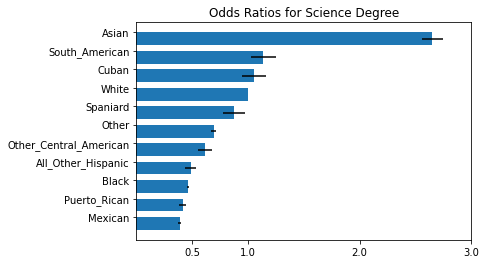

In [59]:
# Graph odds ratios for science degree
ind = np.arange(len(race_odds_ratios)) # how many bars
width = 0.7 # width of bars
fig, ax = plt.subplots()
ax.barh(ind, race_odds_ratios['OR'], width, xerr=race_odds_ratios['error'])

plt.title('Odds Ratios for Science Degree')
plt.yticks(ind + width/2., race_odds_ratios.index.tolist()) # add category labels
# plt.xscale('log') # plot on log scale
ax.get_xaxis().set_major_formatter(ScalarFormatter()) # convert x axis labels to scalar format
plt.xticks([0.5,1,2,3]) # add ticks at these values
plt.show()

##### How to interpret odds ratio?

$logit(p) = 0.5 + 0.13 * study_hours + 0.97 * female$

In the model above, b = 0.13, c = 0.97, and p = P{Y=1} is the probability of passing a math exam. Let’s pick study_hours and see how it impacts the chances of passing the exam. Increasing the study hours by 1 unit (1 hour) will result in a 0.13 increase in logit(p) or log(p/1-p). Now, if log(p/1–p) increases by 0.13, that means that p/(1 — p) will increase by exp(0.13) = 1.14. This is a 14% increase in the odds of passing the exam (assuming that the variable female remains fixed).
Let’s also interpret the impact of being a female on passing the exam. We know that exp(0.97) = 2.64. That being said, the odds for passing the exam are 164% higher for women.

# Effect of Race on Having a Job in STEM

In [26]:
# Repeat the whole thing for the occupation model

# fit occupation model
logit_occ = sm.Logit(df_degree['science_occupation'], df_degree[train_cols_occ]) 

In [68]:
# create dataframe of CIs
result_occ = logit_occ.fit()

result_occ.summary()
params_occ = result_occ.params
conf_occ = np.exp(result_occ.conf_int())
conf_occ['OR'] = np.exp(params_occ)
conf_occ.columns = ['2.5%', '97.5%', 'OR']

# add error column to ocupation CI dataframe, for use in plotting error bars
conf_occ['error'] = conf_occ['97.5%'] - conf_occ['OR']
race_odds_ratios_occ = conf_occ[4:14]

# add a new row for reference category
race_odds_ratios.loc['White'] = [1,1,1,0]
race_odds_ratios_occ = race_odds_ratios_occ.sort_values(by='OR', ascending=True)                               



Optimization terminated successfully.
         Current function value: 0.279981
         Iterations 7


In [69]:
race_odds_ratios_occ

,2.5%,97.5%,OR,error
Mexican,0.580258,0.746895,0.658325,0.088570
Puerto_Rican,0.530092,0.890778,0.687164,0.203614
Other_Central_American,0.500121,0.986941,0.702560,0.284381
South_American,0.523425,1.008089,0.726401,0.281687
Black,0.738176,0.867417,0.800192,0.067226
Other,0.750322,0.951502,0.844945,0.106556
Cuban,0.619049,1.187525,0.857401,0.330124
Spaniard,0.677955,1.374352,0.965271,0.409081
All_Other_Hispanic,0.746244,1.423351,1.030615,0.392736
Asian,0.946997,1.137878,1.038060,0.099819


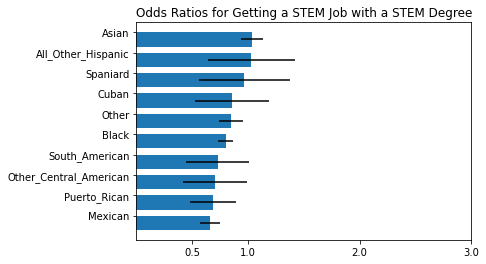

In [76]:
# Graph odds ratios for science occupation model
ind = np.arange(len(race_odds_ratios_occ)) # how many bars
width = 0.7 # width of bars
fig, ax = plt.subplots()
ax.barh(ind, race_odds_ratios_occ['OR'], width, xerr=race_odds_ratios_occ['error'])
plt.title('Odds Ratios for Getting a STEM Job with a STEM Degree')
plt.yticks(ind + width/2., race_odds_ratios_occ.index.tolist()) # add category labels
# plt.xscale('log') # plot on log scale
#ax.get_xaxis().set_major_formatter(ScalarFormatter()) # convert x axis labels to scalar format
plt.xticks([0.5,1,2,3]) # add ticks at these values
plt.show()

In [ ]:
race_odds_ratios.index

# Effect of Place of Birth on Getting a STEM Degree


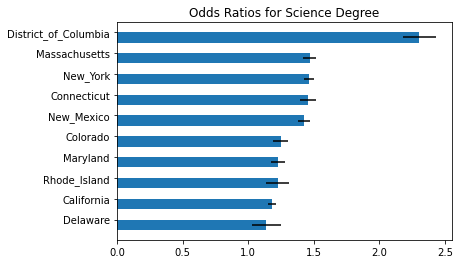

In [57]:
# subset only the variables for state
state_odds_ratios = conf_degree[14:64]
                            
# add a new row for reference category
state_odds_ratios.loc['Pennsylvania'] = [1,1,1,0]

# sort by odds ratio, lowest to highest
state_odds_ratios = state_odds_ratios.sort_values(by='OR', ascending= False)[:10]
state_odds_ratios = state_odds_ratios.sort_values(by='OR', ascending= True)

# Graph odds ratios for science degree
ind = np.arange(10) # how many bars
width = 0.5 # width of bars
fig, ax = plt.subplots()
ax.barh(ind, state_odds_ratios['OR'], width, xerr=state_odds_ratios['error'])
plt.title('Odds Ratios for Science Degree')
plt.yticks(ind + width/2., state_odds_ratios.index.tolist(), fontsize= 10) # add category labels
#plt.xscale('log') # plot on log scale

# ax.get_xaxis().set_major_formatter(ScalarFormatter()) # convert x axis labels to scalar format

plt.savefig('odds_ratios_state_degree.png')
plt.show()


In [30]:
# Create a new blank dataframe for predictions
predict_df = pd.DataFrame(index=range(0,146),columns=train_cols_degree)

# Fill with set values for state and intercept (race doesn't need to be filled in,
# because White is the reference category)
predict_df[['intercept']] = 1
predict_df[['Utah']] = 1

# fill dataframe with all combinations
ages = range(23,96) 
i = 0
for age in ages:
    for sex in [0,1]:
        predict_df['AGEP'][i] = age
        predict_df['SEX'][i] = sex
        i += 1

# recreate interaction variable
predict_df['sex_age'] = predict_df['AGEP']*predict_df['SEX']

# fill all NA values with 0
predict_df.fillna(value=0,inplace=True)

# predict outcome for each combination
predict_df['degree_predict'] = lm_final_degree.predict_proba(predict_df[train_cols_degree])[:,1]
predict_df['occ_predict'] = lm_final_occ.predict_proba(predict_df[train_cols_occ])[:,1]

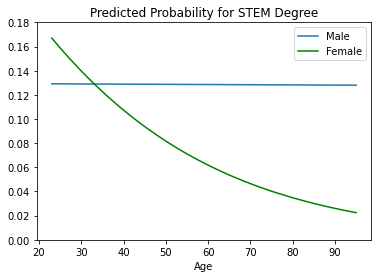

In [60]:
# Plot predicted probas for STEM Degrees
sex_age_chart_degree = predict_df.pivot_table(index='AGEP',values='degree_predict',columns='SEX',aggfunc="mean")
sex_age_chart_degree.columns = ['Male','Female']
sex_age_chart_degree.index.name = 'Age'
sex_age_chart_degree.plot(title='Predicted Probability for STEM Degree', color = ['tab:blue','green'])
plt.ylim(0,0.18)
plt.show()


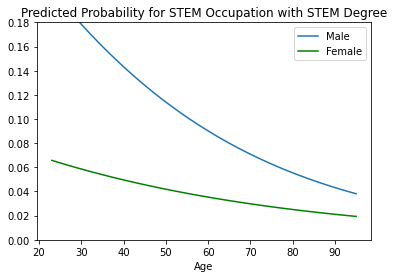

In [61]:
# Plot predicted probas for STEM Occupations
sex_age_chart_occ = predict_df.pivot_table(index='AGEP',values='occ_predict',columns='SEX',aggfunc="mean")
sex_age_chart_occ.columns = ['Male','Female']
sex_age_chart_occ.index.name = 'Age'
sex_age_chart_occ.plot(title='Predicted Probability for STEM Occupation with STEM Degree', color = ['tab:blue','green'])
plt.ylim(0,0.18)
plt.show()


In [34]:
conf_occ


,2.5%,97.5%,OR,error
intercept,0.449558,0.506077,0.476981,0.029096
AGEP,0.972983,0.975304,0.974143,0.001161
SEX,0.196491,0.250192,0.221722,0.028471
sex_age,1.005894,1.011258,1.008572,0.002685
Asian,0.946997,1.137878,1.038060,0.099819
Black,0.738176,0.867417,0.800192,0.067226
Other,0.750322,0.951502,0.844945,0.106556
Mexican,0.580258,0.746895,0.658325,0.088570
Puerto_Rican,0.530092,0.890778,0.687164,0.203614
Cuban,0.619049,1.187525,0.857401,0.330124


In [35]:
conf_degree

,2.5%,97.5%,OR,error
intercept,0.155711,0.164786,0.160184,0.004601
AGEP,0.999188,0.999947,0.999568,0.000380
SEX,2.542655,2.701587,2.620916,0.080670
sex_age,0.970414,0.971563,0.970988,0.000575
Asian,2.557996,2.745337,2.650011,0.095325
...,...,...,...,...
Virginia,1.006231,1.085116,1.044929,0.040187
Washington,1.002100,1.087232,1.043798,0.043434
West_Virginia,0.568506,0.640484,0.603423,0.037061
Wisconsin,0.829890,0.894757,0.861713,0.033044


In [36]:
result_occ.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     science_occupation   No. Observations:               190962
Model:                          Logit   Df Residuals:                   190948
Method:                           MLE   Df Model:                           13
Date:                Tue, 22 Feb 2022   Pseudo R-squ.:                 0.04737
Time:                        13:04:44   Log-Likelihood:                -53466.
converged:                       True   LL-Null:                       -56125.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -0.7403      0.030    -24.504      0.000      -0.799      -0.681
AGEP                      -0.0262      0.001    -43.104      0.000      -0.027      -0.025
SEX                       -1.5063      0.062    -24.439      0.000      -1.627      -1.386
sex_age                    0.0085      0.001      6.292      0.000       0.006       0.011
Asian                      0.0374      0.047      0.797      0.425      -0.054       0.129
Black                     -0.2229      0.041     -5.416      0.000      -0.304      -0.142
Other                     -0.1685      0.061     -2.780      0.005      -0.287      -0.050
Mexican                   -0.4181      0.064     -6.491      0.000      -0.544      -0.292
Puerto_Rican              -0.3752      0.132     -2.833      0.005      -0.635      -0.116
Cuban                     -0.1538      0.166     -0.926      0.355      -0.480       0.172
Spaniard                  -0.0353      0.180     -0.196      0.845      -0.389       0.318
South_American            -0.3197      0.167     -1.912      0.056      -0.647       0.008
Other_Central_American    -0.3530      0.173     -2.036      0.042      -0.693      -0.013
All_Other_Hispanic         0.0302      0.165      0.183      0.855      -0.293       0.353
==========================================================================================
"""

In [37]:
np.exp(-1.5063)

0.22172885887331226

In [38]:
result_degree.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         science_degree   No. Observations:              1900073
Model:                          Logit   Df Residuals:                  1900009
Method:                           MLE   Df Model:                           63
Date:                Tue, 22 Feb 2022   Pseudo R-squ.:                 0.04296
Time:                        13:07:09   Log-Likelihood:            -5.9315e+05
converged:                       True   LL-Null:                   -6.1978e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -1.8314      0.014   -126.743      0.000      -1.860      -1.803
AGEP                      -0.0004      0.000     -2.232      0.026      -0.001   -5.26e-05
SEX                        0.9635      0.015     62.294      0.000       0.933       0.994
sex_age                   -0.0294      0.000    -97.484      0.000      -0.030      -0.029
Asian                      0.9746      0.018     54.050      0.000       0.939       1.010
Black                     -0.7684      0.011    -71.400      0.000      -0.790      -0.747
Other                     -0.3697      0.018    -21.084      0.000      -0.404      -0.335
Mexican                   -0.9493      0.017    -55.453      0.000      -0.983      -0.916
Puerto_Rican              -0.8848      0.034    -25.814      0.000      -0.952      -0.818
Cuban                      0.0528      0.050      1.048      0.294      -0.046       0.151
Spaniard                  -0.1308      0.055     -2.389      0.017      -0.238      -0.023
South_American             0.1288      0.049      2.620      0.009       0.032       0.225
Other_Central_American    -0.4883      0.047    -10.283      0.000      -0.581      -0.395
All_Other_Hispanic        -0.7200      0.049    -14.682      0.000      -0.816      -0.624
Alabama                   -0.3237      0.023    -13.783      0.000      -0.370      -0.278
Alaska                    -0.1545      0.057     -2.721      0.007      -0.266      -0.043
Arizona                   -0.2160      0.030     -7.315      0.000      -0.274      -0.158
Arkansas                  -0.5199      0.030    -17.080      0.000      -0.580      -0.460
California                 0.1660      0.013     12.803      0.000       0.141       0.191
Colorado                   0.2223      0.023      9.692      0.000       0.177       0.267
Connecticut                0.3754      0.021     17.685      0.000       0.334       0.417
Delaware                   0.1292      0.047      2.745      0.006       0.037       0.221
District_of_Columbia       0.8346      0.027     30.838      0.000       0.782       0.888
Florida                   -0.1524      0.019     -8.128      0.000      -0.189      -0.116
Georgia                   -0.2941      0.020    -14.361      0.000      -0.334      -0.254
Hawaii                    -0.2960      0.038     -7.864      0.000      -0.370      -0.222
Idaho                     -0.1733      0.038     -4.550      0.000      -0.248      -0.099
Illinois                   0.0409      0.014      2.847      0.004       0.013       0.069
Indiana                   -0.3017      0.019    -15.564      0.000      -0.340      -0.264
Iowa                      -0.2090      0.022     -9.296      0.000      -0.253      -0.165
Kansas                    -0.1329      0.025     -5.326      0.000      -0.182      -0.084
Kentucky                  -0.4724      0.024    -19.884      0.000      -0.519      -0.426
Louisiana                 -0.3000      0.023    -12.990 

In [39]:
np.exp(0.9635)

2.6208534264000876